## TFG MANEL

### Petita exploració de wordnet, com funciona, com es relaciona, com es l'estructura jerarquica.

1. Importació de llibreries

In [1]:
import nltk
from nltk.corpus import wordnet as wn
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

#### Arbre del wordnet
- Es tracta d'un DAG, graf dirigit aciclic. No hi ha un camí que comenci i acabi en el mateix lloc

#### L'estructura del wordnet es basa en synsets

- Synset = Conjunt de sinònims representats per un d'ells, que té un significat únic. (Unitat Base de wordnet/imagenet)
- Un node recopila tots els sinònims d'aquella paraula dintre del mateix context, dog --> gos, dog --> perrito caliente, difs contexts
-  Cada node de l'arbre és un synset que es relaciona amb altres synsets en forma d'hiponims o hyperonims

#### L'estructura del synsets
- Cada sysnset es representa com : ParaulaClau.TipusParaula.Significat.
- Paraula Base : Paraula que reciopila tota la informació, tots el sinonims. Paraula Representativa
- Tipus de Paraula : Noun, Verb, Adjective, Adverb, etc
- Significat :Numero que identifica els diferents significats d'una paraula que s'escriu igual (paraules homonimes)
ex: dog i dog dog.n.01 = gos, dog.n.02 = perrito caliente

#### Informació dintre del synset
- Nom
- Definició
- Exemples
- Sinònims

#### Hyperonims i Hyponims
- Hyperonims: Són les paraules que tenen un significat més general 
- Hyponims: Són les paraules que tenen un significat més específic
ex: Animal --> gos, gat, etc. (Animal es un hyperonim de gos)
- Per a navegar per l'arbre anirem escalant per hyperonims fins a trobar el hyperonim general per a les paraules

#### Meronyms i Holonims
- Meronyms: Parts d'un concepte , ex : Cotxe --> Roda
- Holonims: Conceptes que estan compostos per meronyms, ex : Roda --> Cotxe

#### Objetivo: 
- Encontrar aquel concepto general que relacione los difernetes top scores de cada una de las neuronas de una capa

#### LCA: Least Common Ancestor
- Conjunto mas general para el conjunto de etiquetas

## COMENÇA L'EXPLORACIÓ

Print de la informació d'un sysnset

In [2]:
dog = wn.synset('dalmatian.n.02')
# Información básica del Synset
print("Nombre del Synset:", dog.name())
print("Definición:", dog.definition())
print("Ejemplos de uso:", dog.examples())
print("Sinónimos:", dog.lemma_names())

Nombre del Synset: dalmatian.n.02
Definición: a large breed having a smooth white coat with black or brown spots; originated in Dalmatia
Ejemplos de uso: []
Sinónimos: ['dalmatian', 'coach_dog', 'carriage_dog']


Hypernims i hyponims

In [3]:
# Obtener los hypernyms de "dog.n.01"
hypernyms = dog.hypernyms()
print("Hypernyms (conceptos más generales):", [h.name() for h in hypernyms])
# Obtener los hyponyms de "dog.n.01"
hyponyms = dog.hyponyms()
print("Hyponyms (conceptos más específicos):", [h.name() for h in hyponyms])

Hypernyms (conceptos más generales): ['dog.n.01']
Hyponyms (conceptos más específicos): ['liver-spotted_dalmatian.n.01']


LCA de dos exemples: gat i gos

In [4]:
# Synsets de "dog" y "cat"
dog = wn.synset('dog.n.01')
cat = wn.synset('cat.n.01')

# Obtener el ancestro común más cercano
lca = dog.lowest_common_hypernyms(cat)
print("Ancestro común más cercano:", lca[0].name(), "-", lca[0].definition())


Ancestro común más cercano: carnivore.n.01 - a terrestrial or aquatic flesh-eating mammal


Obtenir tot el camí, amb la descripció de cada pas

In [5]:
# Obtener las rutas hacia la raíz para "dog.n.01" y "cat.n.01"
dog_paths = dog.hypernym_paths()
cat_paths = cat.hypernym_paths()

# Imprimir rutas
print("Ruta de 'dog.n.01':")
for synset in dog_paths[0]:
    print(f"  {synset.name()} - {synset.definition()}")

print("\nRuta de 'cat.n.01':")
for synset in cat_paths[0]:
    print(f"  {synset.name()} - {synset.definition()}")


Ruta de 'dog.n.01':
  entity.n.01 - that which is perceived or known or inferred to have its own distinct existence (living or nonliving)
  physical_entity.n.01 - an entity that has physical existence
  object.n.01 - a tangible and visible entity; an entity that can cast a shadow
  whole.n.02 - an assemblage of parts that is regarded as a single entity
  living_thing.n.01 - a living (or once living) entity
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently
  animal.n.01 - a living organism characterized by voluntary movement
  chordate.n.01 - any animal of the phylum Chordata having a notochord or spinal column
  vertebrate.n.01 - animals having a bony or cartilaginous skeleton with a segmented spinal column and a large brain enclosed in a skull or cranium
  mammal.n.01 - any warm-blooded vertebrate having the skin more or less covered with hair; young are born alive except for the small subclass of monotremes and nourished with milk

In [6]:
# Listar todos los Synsets de "dog"
dog_synsets = wn.synsets('dog')
for synset in dog_synsets:
    print(f"{synset.name()} - {synset.definition()}")


dog.n.01 - a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds
frump.n.01 - a dull unattractive unpleasant girl or woman
dog.n.03 - informal term for a man
cad.n.01 - someone who is morally reprehensible
frank.n.02 - a smooth-textured sausage of minced beef or pork usually smoked; often served on a bread roll
pawl.n.01 - a hinged catch that fits into a notch of a ratchet to move a wheel forward or prevent it from moving backward
andiron.n.01 - metal supports for logs in a fireplace
chase.v.01 - go after with the intent to catch


Graf per a visualitzar el cami

OJO: Hi ha diferentes camins possibles per a un mateix synset, més d'un hypernim per paraula

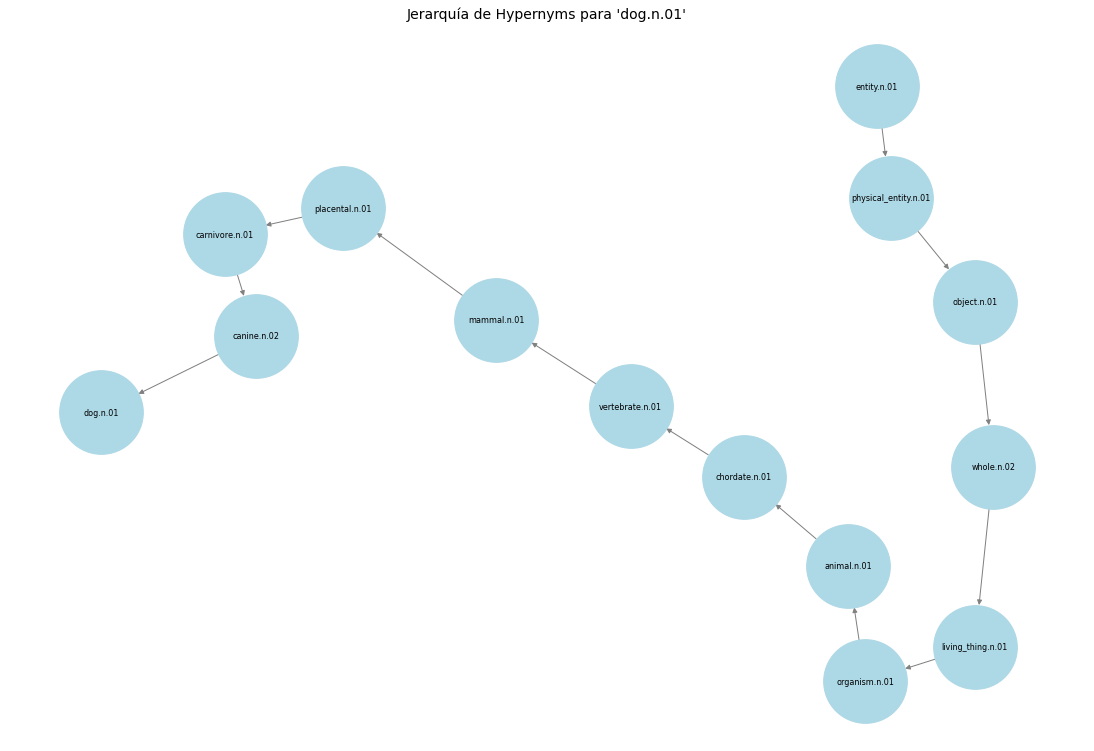

In [7]:
# Crear un grafo
G = nx.DiGraph()

# Añadir nodos y relaciones
for synset in dog.hypernym_paths()[0]:
    G.add_node(synset.name(), label=synset.name())
    if synset.hypernyms():
        G.add_edge(synset.hypernyms()[0].name(), synset.name())

# Configuración del gráfico
plt.figure(figsize=(15, 10))  # Aumentar el tamaño de la figura
pos = nx.spring_layout(G, seed=42)  # Distribución más clara
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=7000,
    node_color="lightblue",
    edge_color="gray",
    font_size=10,
)
# Añadir etiquetas con definiciones más visibles
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center')

plt.title("Jerarquía de Hypernyms para 'dog.n.01'", fontsize=14)
plt.show()



Exemple més extens amb animals

In [8]:
# Lista de etiquetas (10 palabras)
image_labels = ['golden_retriever', 'beagle', 'labrador_retriever', 'wolf', 
                'fox', 'cat', 'lion', 'tiger', 'cheetah', 'dog']

# Convertir etiquetas a Synsets (primer Synset de cada palabra)
synsets = [wn.synsets(label, pos=wn.NOUN)[0] for label in image_labels]

# Mostrar los Synsets y sus definiciones
for synset in synsets:
    print(f"Etiqueta: {synset.name()} - {synset.definition()}")


Etiqueta: golden_retriever.n.01 - an English breed having a long silky golden coat
Etiqueta: beagle.n.01 - a small short-legged smooth-coated breed of hound
Etiqueta: labrador_retriever.n.01 - breed originally from Labrador having a short black or golden-brown coat
Etiqueta: wolf.n.01 - any of various predatory carnivorous canine mammals of North America and Eurasia that usually hunt in packs
Etiqueta: fox.n.01 - alert carnivorous mammal with pointed muzzle and ears and a bushy tail; most are predators that do not hunt in packs
Etiqueta: cat.n.01 - feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats
Etiqueta: lion.n.01 - large gregarious predatory feline of Africa and India having a tawny coat with a shaggy mane in the male
Etiqueta: tiger.n.01 - a fierce or audacious person
Etiqueta: cheetah.n.01 - long-legged spotted cat of Africa and southwestern Asia having nonretractile claws; the swiftest mammal; can be trained to run down game
Etiqueta: do

In [9]:
# Encontrar el ancestro común más cercano
common_ancestor = synsets[0]  # Empezamos con el primer Synset
for synset in synsets[1:]:    # Iteramos sobre los demás
    common_ancestor = common_ancestor.lowest_common_hypernyms(synset)[0]

# Mostrar el resultado
print("Ancestro común más cercano:")
print(f"  {common_ancestor.name()} - {common_ancestor.definition()}")


Ancestro común más cercano:
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently


In [10]:
# Ruta hacia la raíz
hypernym_path = common_ancestor.hypernym_paths()[0]

print("Ruta hacia la raíz:")
for hypernym in hypernym_path:
    print(f"  {hypernym.name()} - {hypernym.definition()}")


Ruta hacia la raíz:
  entity.n.01 - that which is perceived or known or inferred to have its own distinct existence (living or nonliving)
  physical_entity.n.01 - an entity that has physical existence
  object.n.01 - a tangible and visible entity; an entity that can cast a shadow
  whole.n.02 - an assemblage of parts that is regarded as a single entity
  living_thing.n.01 - a living (or once living) entity
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently


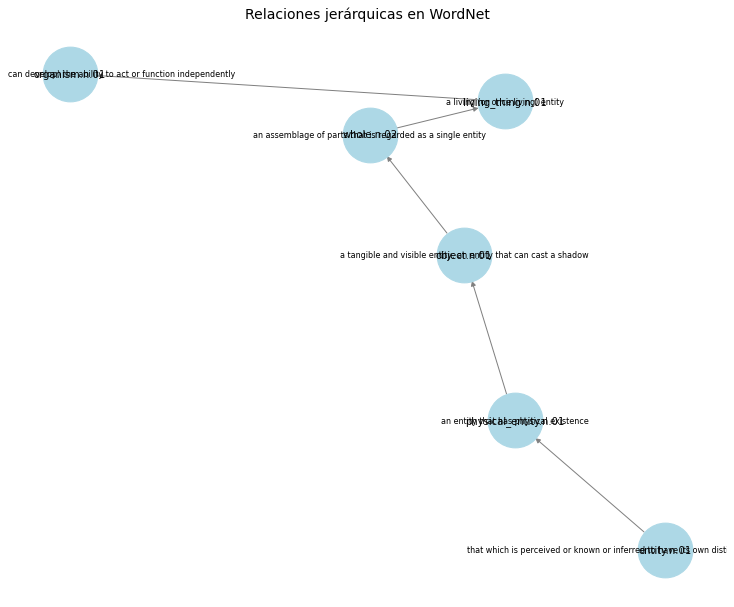

In [11]:
# Crear un grafo
G = nx.DiGraph()

# Añadir nodos y relaciones
for synset in hypernym_path:
    G.add_node(synset.name(), label=synset.definition())
    if synset.hypernyms():
        G.add_edge(synset.hypernyms()[0].name(), synset.name())

# Configurar el gráfico
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center')

plt.title("Relaciones jerárquicas en WordNet", fontsize=14)
plt.show()


## Similaritats entre les definicions

In [12]:
# Definiciones de los Synsets
definitions = [synset.definition() for synset in synsets]

# Calcular vectores TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(definitions)

# Calcular similitud coseno entre las definiciones
similarity_matrix = cosine_similarity(tfidf_matrix)
print("Matriz de similitud:")
print(similarity_matrix)


Matriz de similitud:
[[1.         0.09032877 0.31070855 0.         0.         0.04116789
  0.1054667  0.         0.10414647 0.        ]
 [0.09032877 1.         0.17519629 0.07654285 0.         0.
  0.03958876 0.         0.10041574 0.02964475]
 [0.31070855 0.17519629 1.         0.         0.         0.03461853
  0.08868811 0.12962067 0.02872    0.05298597]
 [0.         0.07654285 0.         1.         0.25748113 0.08343271
  0.17162625 0.         0.06809628 0.09825884]
 [0.         0.         0.         0.25748113 1.         0.08697805
  0.1285766  0.         0.07215818 0.05112363]
 [0.04116789 0.         0.03461853 0.08343271 0.08697805 1.
  0.11460694 0.         0.13225882 0.        ]
 [0.1054667  0.03958876 0.08868811 0.17162625 0.1285766  0.11460694
  1.         0.         0.15539098 0.11366035]
 [0.         0.         0.12962067 0.         0.         0.
  0.         1.         0.         0.        ]
 [0.10414647 0.10041574 0.02872    0.06809628 0.07215818 0.13225882
  0.15539098 0.

In [13]:
# Generar resumen simple
def generate_summary(synsets):
    definitions = [synset.definition() for synset in synsets]
    summary = " Esta neurona responde a conceptos como: " + ", ".join(definitions)
    return summary

# Ejemplo
summary = generate_summary(synsets)
print(summary)


 Esta neurona responde a conceptos como: an English breed having a long silky golden coat, a small short-legged smooth-coated breed of hound, breed originally from Labrador having a short black or golden-brown coat, any of various predatory carnivorous canine mammals of North America and Eurasia that usually hunt in packs, alert carnivorous mammal with pointed muzzle and ears and a bushy tail; most are predators that do not hunt in packs, feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats, large gregarious predatory feline of Africa and India having a tawny coat with a shaggy mane in the male, a fierce or audacious person, long-legged spotted cat of Africa and southwestern Asia having nonretractile claws; the swiftest mammal; can be trained to run down game, a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds


## TASCA 1

- Ens ve la informació per carpetes:
    - 1 Llistes TFG
        - 2 Capes
            - 3 Neurones de cada capa
                - 4 Top 100 imatges de cada una de les neurones

Llegir la informació de les llistes que ens han donat i crar un mapping per a poder tindre en forma de classe de imagenet per a poder fer una posterior cerca

Definiré diferntes funcions:
- 1 Llegir els documents
- 2 Crear el mapping
- 3 Crear nou document amb els synsets de l'imagenet

## Pas 1: Càrrega de les dades de les capes

En aquest pas, carregarem els arxius `.npy` que contenen les dades de les diferents capes de la xarxa neuronal. 
Cada capa conté una matriu on cada fila representa una neurona i les seves imatges associades.

### **Objectiu**
- Llegir els arxius `.npy` de les diferents capes (`relu`, `layer1`, `layer2`, `layer3`).
- Organitzar les dades en un diccionari per accedir-hi fàcilment.
- Verificar la mida de cada capa després de carregar-les.


1.Leer los archivos guardado en formado array

In [14]:
def cargar_datos_capas(base_path, capas):
    """
    Carga los archivos .npy de diferentes capas y los organiza en un diccionario.
    
    Parámetros:
    - base_path: ruta donde están los archivos .npy.
    - capas: lista con los nombres de las capas a cargar.
    
    Retorna:
    - diccionario donde las claves son los nombres de las capas y los valores son los datos cargados.
    """
    datos = {}
    for capa in capas:
        file_path = os.path.join(base_path, f"{capa}.npy")
        if os.path.exists(file_path):
            datos[capa] = np.load(file_path, allow_pickle=True)
            print(f"📥 Cargado {capa} - Shape: {datos[capa].shape}")
        else:
            print(f"⚠️ No se encontró {file_path}")
    return datos

# 📌 Parámetros
base_path = "../Data/"  # Cambia esto si los archivos están en otra carpeta
capas = ["relu", "layer1", "layer2", "layer3"]  # Lista de nombres de capas

# 📥 Cargar todas las capas
datos_capas = cargar_datos_capas(base_path, capas)

📥 Cargado relu - Shape: (64, 100)
📥 Cargado layer1 - Shape: (256, 100)
📥 Cargado layer2 - Shape: (512, 100)
📥 Cargado layer3 - Shape: (1024, 100)


## Pas 2

In [15]:
def wnid_a_synset(wnid):
    """
    Converteix un WNID d'ImageNet a un synset de WordNet utilitzant NLTK.

    Paràmetres:
    - wnid: str, identificador WNID d'ImageNet (exemple: 'n02119789').

    Retorna:
    - Synset de WordNet si existeix, altrament None.
    """
    try:
        synset = wn.synset_from_pos_and_offset('n', int(wnid[1:]))  # Convertim el codi WNID en un synset
        return synset
    except:
        return None

# 📌 Provar amb un WNID d'exemple
wnid_exemple = "n02119789"  # Kit fox
synset = wnid_a_synset(wnid_exemple)

if synset:
    print(f"WNID: {wnid_exemple}")
    print(f"Synset: {synset}")
    print(f"Definició: {synset.definition()}")
    print(f"Sinònims: {synset.lemma_names()}")
else:
    print(f"No s'ha trobat un synset per {wnid_exemple}")


WNID: n02119789
Synset: Synset('kit_fox.n.01')
Definició: small grey fox of southwestern United States; may be a subspecies of Vulpes velox
Sinònims: ['kit_fox', 'Vulpes_macrotis']


In [16]:
def carregar_mapeig_wnid(ruta_fitxer):
    """
    Carrega el fitxer `Image_net_Classes.txt` i construeix un diccionari {WNID: nom_classe}.

    Paràmetres:
    - ruta_fitxer: str, ruta de l'arxiu.

    Retorna:
    - Diccionari {WNID: nom_classe}.
    """
    mapeig = {}
    with open(ruta_fitxer, "r") as f:
        for linia in f:
            parts = linia.strip().split(": ")  # Format: "nxxxxx: nom_classe"
            if len(parts) == 2:
                wnid, nom_classe = parts
                mapeig[wnid] = nom_classe
    return mapeig

# 📌 Càrrega del mapeig
ruta_mapeig = "../Data/Image_net_Classes.txt"  # Ajusta la ruta si cal
mapeig_wnids_manual = carregar_mapeig_wnid(ruta_mapeig)

# 📌 Veiem alguns exemples
list(mapeig_wnids_manual.items())[:5]


[('n02119789', 'kit fox, Vulpes macrotis'),
 ('n02100735', 'English setter'),
 ('n02096294', 'Australian terrier'),
 ('n02066245',
  'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus'),
 ('n02509815',
  'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens')]

In [17]:
def obtenir_synset(wnid, mapeig_manual):
    """
    Intenta obtenir la informació d'un WNID utilitzant WordNet i, si no funciona, usa el mapeig manual.

    Paràmetres:
    - wnid: str, identificador WNID d'ImageNet.
    - mapeig_manual: dict, diccionari {WNID: nom_classe} carregat de `Image_net_Classes.txt`.

    Retorna:
    - Tuple (synset, definició, sinònims).
    """
    synset = wnid_a_synset(wnid)
    if synset:
        return synset, synset.definition(), synset.lemma_names()
    elif wnid in mapeig_manual:
        return None, f"Nom a ImageNet: {mapeig_manual[wnid]}", []
    else:
        return None, "Sense informació", []

# 📌 Provar amb un exemple
wnid_exemple = "n02119789"  # Kit fox
resultat = obtenir_synset(wnid_exemple, mapeig_wnids_manual)

print(f"WNID: {wnid_exemple}")
print(f"Synset: {resultat[0]}")
print(f"Descripció: {resultat[1]}")
print(f"Sinònims: {resultat[2]}")


WNID: n02119789
Synset: Synset('kit_fox.n.01')
Descripció: small grey fox of southwestern United States; may be a subspecies of Vulpes velox
Sinònims: ['kit_fox', 'Vulpes_macrotis']


In [ ]:
def processar_capa_wnids(capa, dades_capas, mapeig_manual):
    """
    Processa totes les neurones d'una capa i obté les seves descripcions semàntiques.

    Paràmetres:
    - capa: str, nom de la capa ('relu', 'layer1', etc.).
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, mapeig {WNID: nom_classe}.

    Retorna:
    - Diccionari {neurona: [(synset, definició, sinònims)]}, on cada neurona té múltiples WNIDs associats.
    """
    if capa not in dades_capas:
        print(f" La capa '{capa}' no existeix.")
        return {}

    capa_wnids = {}  # Diccionari on guardarem les neurones i les seves descripcions
    for neuron_idx, row in enumerate(dades_capas[capa]):  # Iterem per cada neurona
        wnids = {path.split('/')[0] for path in row}  # Extreiem WNIDs únics
        descripcions = [obtenir_synset(wnid, mapeig_manual) for wnid in wnids]
        capa_wnids[f"neuron_{neuron_idx}"] = descripcions  # Guardem les descripcions de cada neurona
    
    return capa_wnids


resultats_layer1 = processar_capa_wnids("layer1", datos_capas, mapeig_wnids_manual)

# 📌 Mostrar les primeres 3 neurones processades
for neurona, descripcions in list(resultats_layer1.items()):
    print(f"\n🔹 {neurona}:")
    for descripcio in descripcions:  # Només mostrem les primeres 5 classes per neurona
        print(f"  - Synset: {descripcio[0]}")
        print(f"    Definició: {descripcio[1]}")
        print(f"    Sinònims: {descripcio[2]}")


Funció Main per a poder processar totes les capes alhora i crear un json amb els synsets que hem mapejat

In [27]:
def processar_totes_les_capes(dades_capas, mapeig_manual):
    """
    Processa totes les capes disponibles i obté les descripcions semàntiques de les seves neurones.

    Paràmetres:
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, mapeig {WNID: nom_classe}.

    Retorna:
    - Diccionari {capa: {neurona: [(synset, definició, sinònims)]}}, estructurat per capa i neurona.
    """
    resultats = {}
    for capa in dades_capas.keys():
        print(f"Processant capa: {capa}")
        resultats[capa] = processar_capa_wnids(capa, dades_capas, mapeig_manual)
    
    return resultats

# 📌 Processar totes les capes
resultats_totals = processar_totes_les_capes(datos_capas, mapeig_wnids_manual)

# 📌 Mostrar algunes neurones processades per cada capa
for capa, neurones in resultats_totals.items():
    print(f"\nCapa: {capa}")
    for neurona, descripcions in list(neurones.items())[:3]:  # Mostrem només 3 neurones per capa
        print(f"\n  Neurona: {neurona}")
        for descripcio in descripcions[:5]:  # Mostrem només les primeres 5 classes per neurona
            print(f"    - Synset: {descripcio[0]}")
            print(f"      Definició: {descripcio[1]}")
            print(f"      Sinònims: {descripcio[2]}")


Processant capa: relu
Processant capa: layer1
Processant capa: layer2
Processant capa: layer3

Capa: relu

  Neurona: neuron_0
    - Synset: Synset('boathouse.n.01')
      Definició: a shed at the edge of a river or lake; used to store boats
      Sinònims: ['boathouse']
    - Synset: Synset('breastplate.n.01')
      Definició: armor plate that protects the chest; the front part of a cuirass
      Sinònims: ['breastplate', 'aegis', 'egis']
    - Synset: Synset('tape_player.n.01')
      Definició: electronic equipment for playing back magnetic tapes
      Sinònims: ['tape_player']
    - Synset: Synset('miniskirt.n.01')
      Definició: a very short skirt
      Sinònims: ['miniskirt', 'mini']
    - Synset: Synset('paddle.n.04')
      Definició: a short light oar used without an oarlock to propel a canoe or small boat
      Sinònims: ['paddle', 'boat_paddle']

  Neurona: neuron_1
    - Synset: Synset('tape_player.n.01')
      Definició: electronic equipment for playing back magnetic tapes

Impresio de tots els resultats que hem obtingut.

Es un json amb {layer : {neurona x : [(synset,descr,nom)]}}

In [31]:
def convertir_a_serializable(dades):
    """
    Convierte los datos en un formato serializable para JSON.
    - Convierte los objetos Synset en strings.
    """
    dades_serialitzables = {}
    for capa, neurones in dades.items():
        dades_serialitzables[capa] = {}
        for neurona, descripcions in neurones.items():
            dades_serialitzables[capa][neurona] = [
                (str(synset), definicio, sinonims) for synset, definicio, sinonims in descripcions
            ]
    return dades_serialitzables


In [33]:
import json

# Convertir los datos para que sean serializables
resultats_serialitzats = convertir_a_serializable(resultats_totals)

# Ruta donde queremos guardar el archivo
ruta_fitxer = "../Data/resultats_neurones_wordnet.json"

# Guardar los datos en formato JSON
with open(ruta_fitxer, "w", encoding="utf-8") as f:
    json.dump(resultats_serialitzats, f, indent=4, ensure_ascii=False)

print(f"Resultats guardats a {ruta_fitxer}")



Resultats guardats a ../Data/resultats_neurones_wordnet.json


In [ ]:
# Creem el file_path on tenim el fitxer txt que volem llegir
file_path = "../Data/Image_net_Classes.txt"

if os.path.exists(file_path):
    print("L'arxiu existeix")
else:
    print("L'arxiu no existeix")

L'arxiu existeix


2. Fem la lectura del file i extraiem la informació

In [ ]:
def read_wnid_mapping(file_path):
    """
    Lee un archivo de texto y extrae los WordNet IDs (WNID) junto con su descripción,
    devolviendo un diccionario {WNID: Descripción}.

    Args:
        file_path (str): Ruta del archivo a leer.

    Returns:
        dict: Diccionario {WNID: Descripción}.
    """
    if not os.path.exists(file_path):
        print(f"Error: El archivo {file_path} no existe.")
        return {}

    with open(file_path, "r", encoding="utf-8") as f:
        wnid_dict = {
            line.split(":")[0]: line.split(":")[1].strip()
            for line in f if line.strip()
        }

    return wnid_dict

# Usar la función
wnid_dict = read_wnid_mapping(file_path)

# Mostrar algunos ejemplos
for wnid, description in list(wnid_dict.items())[:5]:
    print(f"{wnid}: {description}")


n02119789: kit fox, Vulpes macrotis
n02100735: English setter
n02096294: Australian terrier
n02066245: grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
n02509815: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens


In [ ]:
wnid_dict

{'n02119789': 'kit fox, Vulpes macrotis',
 'n02100735': 'English setter',
 'n02096294': 'Australian terrier',
 'n02066245': 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 'n02509815': 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 'n02124075': 'Egyptian cat',
 'n02417914': 'ibex, Capra ibex',
 'n02123394': 'Persian cat',
 'n02125311': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 'n02423022': 'gazelle',
 'n02346627': 'porcupine, hedgehog',
 'n02077923': 'sea lion',
 'n02447366': 'badger',
 'n02109047': 'Great Dane',
 'n02092002': 'Scottish deerhound, deerhound',
 'n02071294': 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 'n02442845': 'mink',
 'n02504458': 'African elephant, Loxodonta africana',
 'n02114712': 'red wolf, maned wolf, Canis rufus, Canis niger',
 'n02128925': 'jaguar, panther, Panthera onca, Felis onca',
 'n02117135': 'hyena, hyaena',
 'n02493509': 'titi, titi monk

## Funció 3 

Crear un mapping de wnids als fitxers de les layers

Per a cada neurona tindrem una llista amb els wnids de les imatges que més activen aquella neurona

Guardem informació de les conversions :
- Conversion rate
- Class distribution

In [ ]:
from collections import Counter

UNKNOWN_CLASS = "unk"

def map_neuron_wnids_to_classes(neuron_wnids, wnid_dict):
    """
    Converteix una llista de WNIDs activats en noms de classes.

    Args:
        neuron_wnids (dict): Diccionari {neurona: llista de WNIDs}.
        wnid_dict (dict): Diccionari {WNID: Classe}.

    Returns:
        dict: Diccionari {neurona: llista de noms de classes}.
        dict: Estadístiques de conversió per neurona.
    """
    
    if not isinstance(neuron_wnids, dict) or not isinstance(wnid_dict, dict):
        raise ValueError("Els arguments han de ser diccionaris vàlids.")

    neuron_classes = {}
    conversion_stats = {}

    for neuron, wnids in neuron_wnids.items():
        classes = [wnid_dict.get(wnid, UNKNOWN_CLASS) for wnid in wnids]
        valid_classes = [c for c in classes if c != UNKNOWN_CLASS]

        neuron_classes[neuron] = valid_classes

        total_wnids = len(wnids)
        mapped_classes = len(valid_classes)
        conversion_rate = (mapped_classes / total_wnids * 100) if total_wnids > 0 else 0

        # Contar correctamente las ocurrencias de cada clase
        class_counts = Counter(valid_classes)
        total_valid = sum(class_counts.values())  # Total real de instancias de clases

        if total_valid > 0:
            class_distribution = {c: (count / total_valid * 100) for c, count in class_counts.items()}
        else:
            class_distribution = {}

        # Debugging
        print(f"\nNeuron: {neuron}")
        print(f"Classes count: {class_counts}")
        print(f"Total valid: {total_valid}")
        print(f"Class distribution: {class_distribution}")

        conversion_stats[neuron] = {
            "total_wnids": total_wnids,
            "mapped_classes": mapped_classes,
            "conversion_rate": conversion_rate,
            "class_distribution": class_distribution
        }

    return neuron_classes, conversion_stats


In [ ]:
neuron_classes, conversion_stats = map_neuron_wnids_to_classes(neuron_wnids, wnid_dict)
# Mostrar la conversión
for neuron, classes in neuron_classes.items():
    print(f"\n {neuron}: {classes}")



Neuron: neuron_0
Classes count: Counter({'boxer': 1, 'eggnog': 1, 'hammer': 1, 'ostrich, Struthio camelus': 1, 'Indian cobra, Naja naja': 1, 'African chameleon, Chamaeleo chamaeleon': 1, 'wooden spoon': 1, 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle': 1, 'Scotch terrier, Scottish terrier, Scottie': 1, 'park bench': 1, 'bee': 1, 'acorn squash': 1, 'gondola': 1, 'hoopskirt, crinoline': 1, 'hotdog, hot dog, red hot': 1, 'coffee mug': 1, 'Chihuahua': 1, 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus': 1, 'lycaenid, lycaenid butterfly': 1, 'Pembroke, Pembroke Welsh corgi': 1, 'Petri dish': 1, 'beer bottle': 1, 'jersey, T-shirt, tee shirt': 1, 'rubber eraser, rubber, pencil eraser': 1, 'Samoyed, Samoyede': 1, 'Christmas stocking': 1, 'plow, plough': 1, 'papillon': 1, 'electric ray, crampfish, numbfish, torpedo': 1, 'Norfolk terrier': 1, 'custard apple': 1, 'bottlecap': 1, 'ladle': 1, 'sundial': 1, 'grille, radiator grille': 1, 'mask': 1, 'odometer, h

In [ ]:
def display_conversion_stats(conversion_stats):
    """
    Mostra estadístiques de conversió de WNIDs a classes per neurona.

    Args:
        conversion_stats (dict): Diccionari d'estadístiques {neurona: dades}.
    """
    for neuron, stats in conversion_stats.items():
        print(f"\n Neurona: {neuron}")
        print(f"   - WNIDs totals: {stats['total_wnids']}")
        print(f"   - WNIDs convertits a classes: {stats['mapped_classes']}")
        print(f"   - Taxa de conversió: {stats['conversion_rate']:.2f}%")

        print("   - Distribució de classes:")
        sorted_classes = sorted(stats['class_distribution'].items(), key=lambda x: x[1], reverse=True)

        for cls, pct in sorted_classes[:5]:  # Mostrar només les 5 classes més comunes
            print(f"     🔹 {cls}: {pct:.2f}%")

# Executar l'anàlisi
display_conversion_stats(conversion_stats)



 Neurona: neuron_0
   - WNIDs totals: 94
   - WNIDs convertits a classes: 94
   - Taxa de conversió: 100.00%
   - Distribució de classes:
     🔹 boxer: 1.06%
     🔹 eggnog: 1.06%
     🔹 hammer: 1.06%
     🔹 ostrich, Struthio camelus: 1.06%
     🔹 Indian cobra, Naja naja: 1.06%

 Neurona: neuron_1
   - WNIDs totals: 49
   - WNIDs convertits a classes: 49
   - Taxa de conversió: 100.00%
   - Distribució de classes:
     🔹 tree frog, tree-frog: 2.04%
     🔹 car wheel: 2.04%
     🔹 bulbul: 2.04%
     🔹 oystercatcher, oyster catcher: 2.04%
     🔹 box turtle, box tortoise: 2.04%

 Neurona: neuron_2
   - WNIDs totals: 70
   - WNIDs convertits a classes: 70
   - Taxa de conversió: 100.00%
   - Distribució de classes:
     🔹 Border collie: 1.43%
     🔹 Rottweiler: 1.43%
     🔹 tree frog, tree-frog: 1.43%
     🔹 safe: 1.43%
     🔹 space bar: 1.43%

 Neurona: neuron_3
   - WNIDs totals: 67
   - WNIDs convertits a classes: 67
   - Taxa de conversió: 100.00%
   - Distribució de classes:
     🔹 New